<a href="https://colab.research.google.com/github/Abdullah-Mohammad-Shakib/Machine-Learning-Project/blob/main/proposed_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# dataset path
path = '/content/drive/MyDrive/Bangla_News_Classification.xlsx'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Total number of headlines: 72044
Total number of headlines: 72044


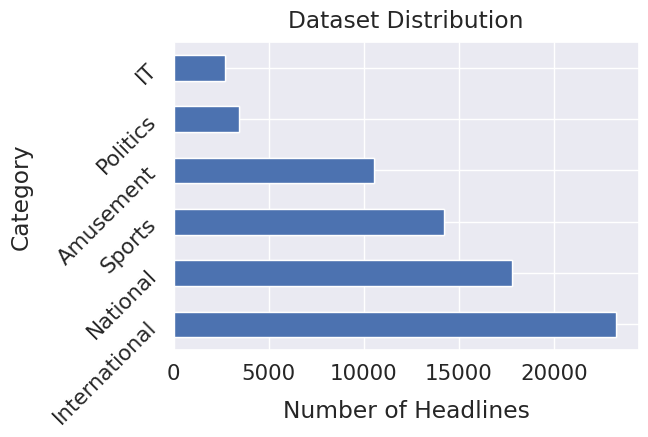

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/ML/csv_file/Bangla_News_Classification.xlsx', engine='openpyxl')

print(f'Total number of headlines: {len(data)}')
sns.set(font_scale=1.4)
data['category'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of Headlines", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02)
print(f'Total number of headlines: {len(data)}')
sns.set(font_scale=1.4)
data['category'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of Headlines", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [ ]:
data.head(5)

,headline,category,newspaper name
0,"হঠাৎ করে কেঁদে ফেললেন ঐশ্বরিয়া রাই, কেন!",Amusement,Jugantor
1,এত দামি জুতা পরেন প্রিয়াঙ্কা!,Amusement,Jugantor
2,মৃত্যুর আগে শ্রীদেবীর শেষ ভিডিও,Amusement,Jugantor
3,কৌতুক অভিনেতা কপিল শর্মার ঘরে নতুন অতিথি,Amusement,Jugantor
4,নিশিকন্যাদের উৎপাতে বাড়ি ছাড়ছেন শাহিদ কাপুর!,Amusement,Jugantor


In [ ]:
data.tail(5)

,headline,category,newspaper name
72039,সংশোধনী,National,Dainik Inqilab
72040,কাজের জিনিস ফিটকিরি,National,Dainik Inqilab
72041,দোষ চাপানো বিএনপির অভ্যাস,National,Dainik Inqilab
72042,ব্যবসায়ীদের জন্য আমার দরজা সব সময় খোলা -প্রধান...,National,Dainik Inqilab
72043,এগিয়ে ইকরামুল হক টিটু,National,Dainik Inqilab


In [ ]:
data.columns

Index(['headline', 'category', 'newspaper name'], dtype='object')

In [ ]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_data(row):
    headlines = re.sub('[^\u0980-\u09FF]',' ',str(row)) #removing unnecessary punctuation
    return headlines
# Apply the function into the dataframe
data['cleaned'] = data['headline'].apply(cleaning_data)

# print some cleaned reviews from the dataset
sample_data = [2000,5000,10000,20000,30000,35000,40000,45000,50000,60000,65000,70000,75000,80000,100000]
# Ensure sample_data indices are within the bounds of the DataFrame
sample_data = [i for i in sample_data if i < len(data)]
for i in sample_data:
    print('Original: ',data.headline[i],'\nCleaned:',
            data.cleaned[i],'\n','Category:-- ',data.category[i],'\n')

Original:  স্ত্রীর সঙ্গে রুবেলের ঘনিষ্ট ছবি দেখে যা বললেন হ্যাপি 
Cleaned: স্ত্রীর সঙ্গে রুবেলের ঘনিষ্ট ছবি দেখে যা বললেন হ্যাপি 
 Category:--  Amusement 

Original:  আইফোন ১০ আরের দাম কমিয়েছে অ্যাপল 
Cleaned: আইফোন ১০ আরের দাম কমিয়েছে অ্যাপল 
 Category:--  IT 

Original:  এক কোম্পানির হাতে ঝুলছে সৌদির অর্থনীতি 
Cleaned: এক কোম্পানির হাতে ঝুলছে সৌদির অর্থনীতি 
 Category:--  International 

Original:  ভারতের অভ্যন্তরীণ বিষয়ে মন্তব্য করতে চাই না: স্বরাষ্ট্রমন্ত্রী 
Cleaned: ভারতের অভ্যন্তরীণ বিষয়ে মন্তব্য করতে চাই না  স্বরাষ্ট্রমন্ত্রী 
 Category:--  National 

Original:  দিল্লিতে আকাশপথে হামলা শঙ্কায় নিরাপত্তা জোরদার 
Cleaned: দিল্লিতে আকাশপথে হামলা শঙ্কায় নিরাপত্তা জোরদার 
 Category:--  International 

Original:  দ. চীন সাগরে গোয়েন্দা ড্রোন বিমান মোতায়েন করেছে বেইজিং 
Cleaned: দ  চীন সাগরে গোয়েন্দা ড্রোন বিমান মোতায়েন করেছে বেইজিং 
 Category:--  International 

Original:  জাভেদকে আইসিসির জন্মদিনের শুভেচ্ছা 
Cleaned: জাভেদকে আইসিসির জন্মদিনের শুভেচ্ছা 
 Category:--  Sports 

Original:  

In [ ]:
# Length of each headlines
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the headlines with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Headlines".format(len(data)-len(dataset)),
      "\nTotal Headlines:",len(dataset))

After Cleaning: 
Removed 2247 Small Headlines 
Total Headlines: 69797


In [ ]:
def data_summary(dataset):

    """
    This function will print the summary of the headlines and words distribution in the dataset.

    Args:
        dataset: list of cleaned sentences

    Returns:
        Number of documnets per class: int
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.category.value_counts().to_dict().items()]
  # find word list
    for label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.category==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.category==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.category==label].cleaned))))
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)




Class Name :  International
Number of Documents:22761
Number of Words:144803
Number of Unique Words:20100
Most Frequent Words:

নিহত	1692
না	960
ট্রাম্প	802
মার্কিন	756
নিয়ে	737
ও	672
ট্রাম্পের	610
থেকে	583
যুক্তরাষ্ট্র	575
বিরুদ্ধে	533

Class Name :  National
Number of Documents:17524
Number of Words:112404
Number of Unique Words:17529
Most Frequent Words:

না	1063
হবে	892
ও	889
প্রধানমন্ত্রী	688
আজ	527
কাদের	448
বিএনপি	437
থেকে	429
খালেদা	410
নিয়ে	407

Class Name :  Sports
Number of Documents:13071
Number of Words:63293
Number of Unique Words:11869
Most Frequent Words:

বাংলাদেশ	659
না	436
জয়	405
বাংলাদেশের	376
শুরু	366
শেষ	270
নিয়ে	262
সাকিব	261
ভারত	259
প্রথম	253

Class Name :  Amusement
Number of Documents:10276
Number of Words:62505
Number of Unique Words:12871
Most Frequent Words:

নতুন	726
নিয়ে	703
ও	639
গান	424
ভিডিও	355
না	311
নাটক	298
খান	293
আজ	274
চলচ্চিত্র	265

Class Name :  Politics
Number of Documents:3463
Number of Words:24580
Number of Unique Words:5521
Most Frequent

<ipython-input-11-a802ad49d523>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(class_names, rotation=45);


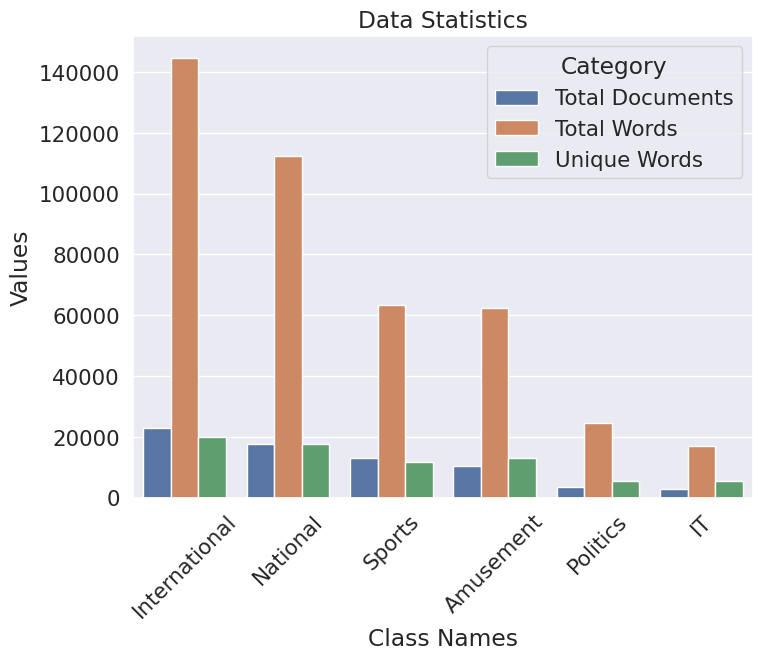

In [ ]:

data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

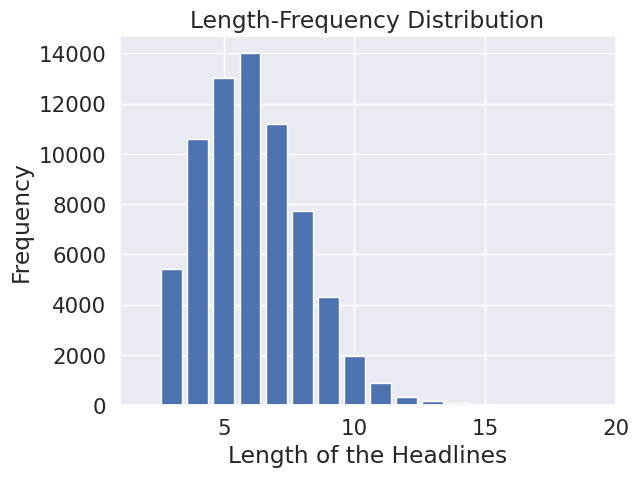

Maximum Length of a headline: 21
Minimum Length of a headline: 3
Average Length of a headline: 6.0


In [ ]:

# Calculate the Review of each of the Review
dataset['HeadlineLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.HeadlineLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 20)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Headlines')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a headline: {max(dataset.HeadlineLength)}")
print(f"Minimum Length of a headline: {min(dataset.HeadlineLength)}")
print(f"Average Length of a headline: {round(np.mean(dataset.HeadlineLength),0)}")

In [ ]:
def label_encoding(category,bool):
    """
    This function will return the encoded labels in array format.

    Args:
        category: series of class names(str)
        bool: boolean (True or False)

    Returns:
        labels: numpy array
    """
    le = LabelEncoder()
    le.fit(category)
    encoded_labels = le.transform(category)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        # Ensure sample_data indices are within the bounds of the category Series
        for i in [index for index in sample_data if index < len(category)]:
            print(category.iloc[i],' ', encoded_labels[i],'\n') # Use iloc to access by position

    return labels




#Dataset_Splitting_Function


def dataset_split(headlines,category):
    """
    This function will return the splitted (90%-10%-10%) feature vector .

    Args:
        headlines: sequenced headlines
        category: encoded lables (array)

    Returns:
        X_train: training data
        X_valid: validation data
        X_test : testing feature vector
        y_train: training encoded labels (array)
        y_valid: training encoded labels (array)
        y_test : testing encoded labels (array)
    """

    X,X_test,y,y_test = train_test_split(headlines,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print(color.BOLD+"\nDataset Distribution:\n"+color.END)
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(headlines),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))

    return X_train,X_valid,X_test,y_train,y_valid,y_test


In [ ]:
labels = label_encoding(dataset.category,True)


			===== Label Encoding ===== 
Class Names:--> ['Amusement' 'IT' 'International' 'National' 'Politics' 'Sports']
Amusement   0 

IT   1 

International   2 

Sports   5 

International   2 

International   2 

Sports   5 

Sports   5 

Amusement   0 

National   3 

National   3 



In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(dataset.headline,labels)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 69797 
	Training		 50253 
	Test			 6980 
	Validation		 12564


In [ ]:
vocab_size = 57000
embedding_dim = 64
max_length = 21
trunc_type='post'
padding_type='post'
oov_tok = ""

def padded_headlines(original,encoded,padded):
  '''
  print the samples padded headlines
  '''
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")
  print(original,"\n",encoded)
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,original,"\n",padded)

In [ ]:
# Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

In [ ]:

(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)

print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

			====== Tokenizer Info ======
Words --> Counts:
না 	 2146
ও 	 1866
নিয়ে 	 1669
নিহত 	 1379
নতুন 	 1315
হবে 	 1207
থেকে 	 1105
সঙ্গে 	 857
আজ 	 856
বাংলাদেশ 	 852

Words --> Documents:
না 	 2091
ও 	 1849
নিয়ে 	 1664
নিহত 	 1377
নতুন 	 1303
হবে 	 1204
থেকে 	 1102
আজ 	 856
সঙ্গে 	 852
শুরু 	 851

Words --> Index:
খেলছেন’ 	 39856
‘রাজনীতি 	 39855
মধ্যস্থতাকারীরা 	 39854
বাবলুর 	 39853
ফুঁ 	 39852
দেয়ালজুড়ে 	 39851
সফিকুলের 	 39850
ল²ীপুরে 	 39849
‘অধিকৃত 	 39848
শিখিয়েছেন 	 39847

Total Documents --> 50253
Found 39856 unique tokens


In [ ]:
padded_headlines(X_train.iloc[10],train_sequences[10],train_padded[10])


			====== Encoded Sequences ====== 

বিধ্বস্ত বিমানের খোঁজে সাগরের নেমে ডুবুরির মৃত্যু 
 [357, 835, 8938, 4676, 2529, 8939, 91]

			====== Paded Sequences ======
 বিধ্বস্ত বিমানের খোঁজে সাগরের নেমে ডুবুরির মৃত্যু 
 [ 357  835 8938 4676 2529 8939   91    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


In [ ]:
# Validation Data Tokenization
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, padding=padding_type , maxlen=max_length)
# Access an element within the valid index range of X_valid, for instance, element at index 1
padded_headlines(X_valid.iloc[1],validation_sequences[1],validation_padded[1])


			====== Encoded Sequences ====== 

অভিনয়ে ফিরছেন কেয়া 
 [573, 282, 8192]

			====== Paded Sequences ======
 অভিনয়ে ফিরছেন কেয়া 
 [ 573  282 8192    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type , maxlen=max_length)
# Access an element using .iloc[] to address by position
padded_headlines(X_test.iloc[100],test_sequences[100],test_padded[100])


			====== Encoded Sequences ====== 

ফিলিস্তিন-ইসরায়েলের মানচিত্র দেখিয়ে ইসরায়েলের সীমানা কতটুকু জানতে চাইলেন এরদোগান 
 [1550, 4589, 4740, 3295, 4589, 5747, 9693, 1429, 487, 350]

			====== Paded Sequences ======
 ফিলিস্তিন-ইসরায়েলের মানচিত্র দেখিয়ে ইসরায়েলের সীমানা কতটুকু জানতে চাইলেন এরদোগান 
 [1550 4589 4740 3295 4589 5747 9693 1429  487  350    0    0    0    0
    0    0    0    0    0    0    0]


In [ ]:
train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

**BERT**

In [ ]:
!pip install --upgrade transformers

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
!pip install --upgrade transformers # Update the transformers library to the latest version

**Xlm-RoBERTa (Proposed model)**



In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
df = pd.read_excel('/content/drive/MyDrive/ML/csv_file/Bangla_News_Classification.xlsx', engine='openpyxl')
df['headline'] = df['headline'].astype(str)

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['headline'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Tokenizer and model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=64)

# Dataset class
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = NewsDataset(train_encodings, train_labels.tolist())
test_dataset = NewsDataset(test_encodings, test_labels.tolist())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# ===== Training =====
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        running_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=-1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)

        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    print(f"\nEpoch {epoch+1} Loss: {avg_loss:.4f} | Train Accuracy: {acc:.4f}")

# ===== Evaluation =====
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(batch['labels'].cpu().numpy())

# Metrics
acc = accuracy_score(all_true, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average='weighted')
report = classification_report(all_true, all_preds, target_names=le.classes_, digits=4)

print("\n=== Test Set Results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:\n", report)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 901/901 [07:41<00:00,  1.95it/s, loss=0.508]



Epoch 1 Loss: 0.6798 | Train Accuracy: 0.7556


Epoch 2/10: 100%|██████████| 901/901 [07:43<00:00,  1.94it/s, loss=0.327]



Epoch 2 Loss: 0.4488 | Train Accuracy: 0.8411


Epoch 3/10: 100%|██████████| 901/901 [07:44<00:00,  1.94it/s, loss=0.614]



Epoch 3 Loss: 0.3659 | Train Accuracy: 0.8709


Epoch 4/10: 100%|██████████| 901/901 [07:45<00:00,  1.94it/s, loss=0.296]



Epoch 4 Loss: 0.3114 | Train Accuracy: 0.8897


Epoch 5/10: 100%|██████████| 901/901 [07:44<00:00,  1.94it/s, loss=0.518]



Epoch 5 Loss: 0.2608 | Train Accuracy: 0.9084


Epoch 6/10: 100%|██████████| 901/901 [07:43<00:00,  1.94it/s, loss=0.317]



Epoch 6 Loss: 0.2217 | Train Accuracy: 0.9227


Epoch 7/10: 100%|██████████| 901/901 [07:43<00:00,  1.94it/s, loss=0.33]



Epoch 7 Loss: 0.1878 | Train Accuracy: 0.9353


Epoch 8/10: 100%|██████████| 901/901 [07:44<00:00,  1.94it/s, loss=0.281]



Epoch 8 Loss: 0.1601 | Train Accuracy: 0.9453


Epoch 9/10: 100%|██████████| 901/901 [07:44<00:00,  1.94it/s, loss=0.172]



Epoch 9 Loss: 0.1421 | Train Accuracy: 0.9524


Epoch 10/10: 100%|██████████| 901/901 [07:43<00:00,  1.94it/s, loss=0.107]



Epoch 10 Loss: 0.1248 | Train Accuracy: 0.9587

=== Test Set Results ===
Accuracy : 0.8701
Precision: 0.8712
Recall   : 0.8701
F1 Score : 0.8704

Classification Report:
                precision    recall  f1-score   support

    Amusement     0.8963    0.9124    0.9043      2112
           IT     0.8250    0.7657    0.7943       542
International     0.9024    0.8995    0.9009      4655
     National     0.8309    0.8062    0.8184      3560
     Politics     0.6175    0.7013    0.6568       693
       Sports     0.9224    0.9315    0.9269      2847

     accuracy                         0.8701     14409
    macro avg     0.8324    0.8361    0.8336     14409
 weighted avg     0.8712    0.8701    0.8704     14409



**ROC**

<ipython-input-28-5b39df1bb60c>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


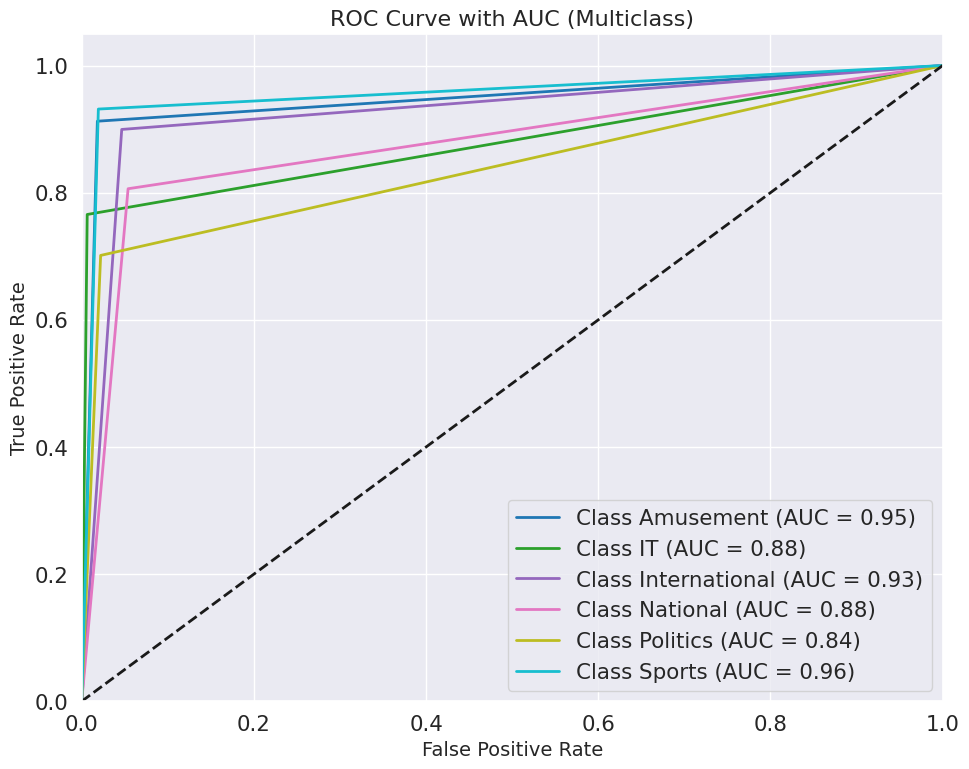

In [ ]:
# ROC Curve (Multiclass) and AUC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels for multiclass ROC
n_classes = len(le.classes_)
true_binarized = label_binarize(all_true, classes=list(range(n_classes)))
pred_binarized = label_binarize(all_preds, classes=list(range(n_classes)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_binarized[:, i], pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             lw=2, label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve with AUC (Multiclass)', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300)  # Save as high-res PNG
plt.show()


**Confusion**

<Figure size 1800x1500 with 0 Axes>

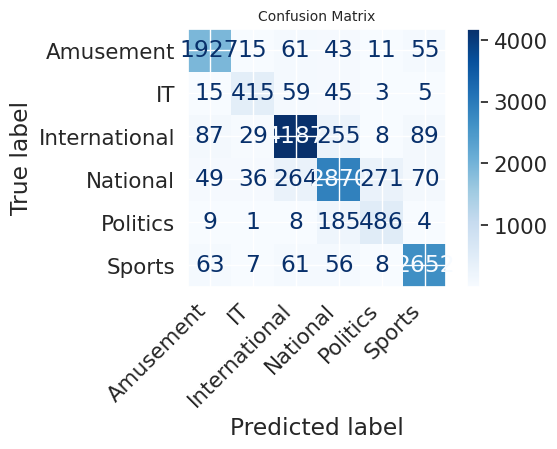

In [ ]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(18, 15))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)  # Save as high-res PNG
plt.show()


**LEarning**

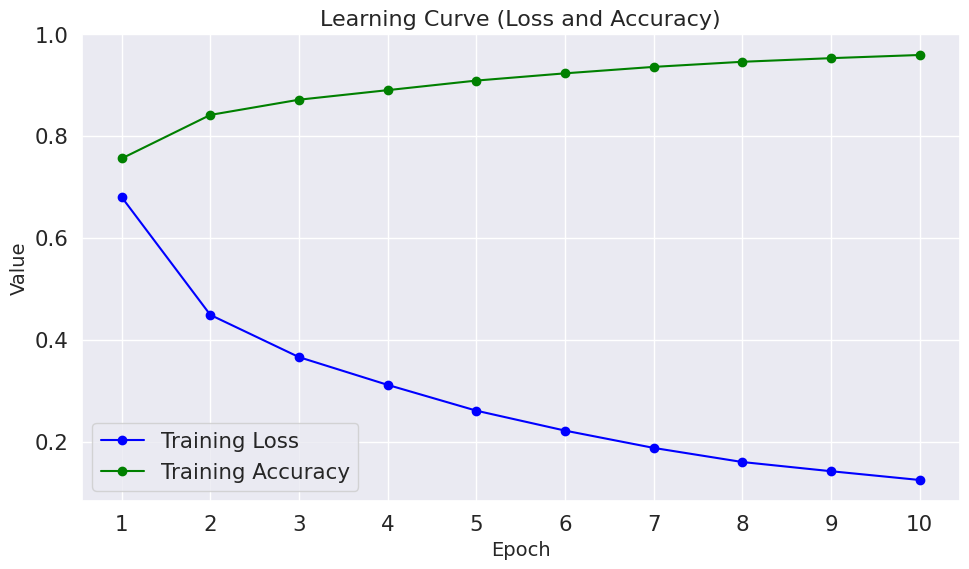

In [ ]:
# Learning Curve (Loss and Accuracy vs Epoch)
plt.figure(figsize=(10, 6))
epochs_range = range(1, num_epochs + 1)

plt.plot(epochs_range, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', color='green', marker='o')

plt.title('Learning Curve (Loss and Accuracy)', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(epochs_range)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('learning_curve.png', dpi=300)  # Save as high-res PNG
plt.show()


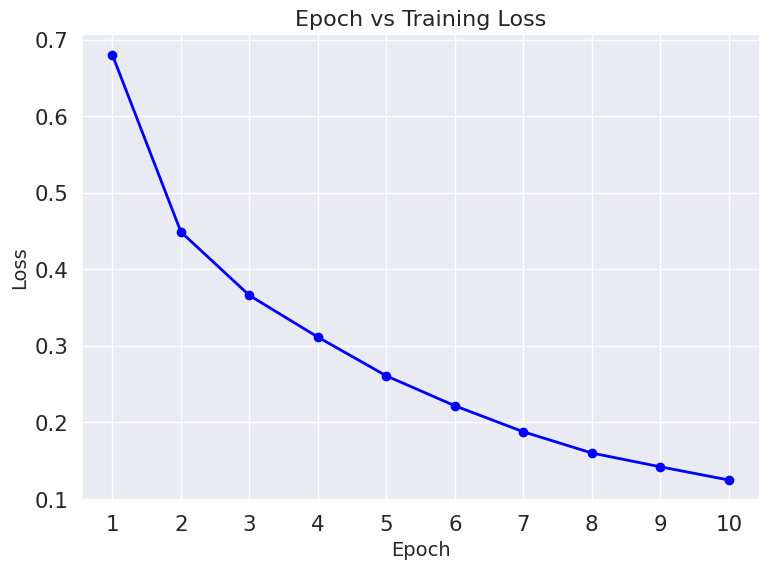

In [ ]:
# Training Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, color='blue', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('Epoch vs Training Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(1, num_epochs + 1))
plt.grid(True)
plt.tight_layout()
plt.savefig('epoch_vs_loss.png', dpi=300)
plt.show()


**calssification report**

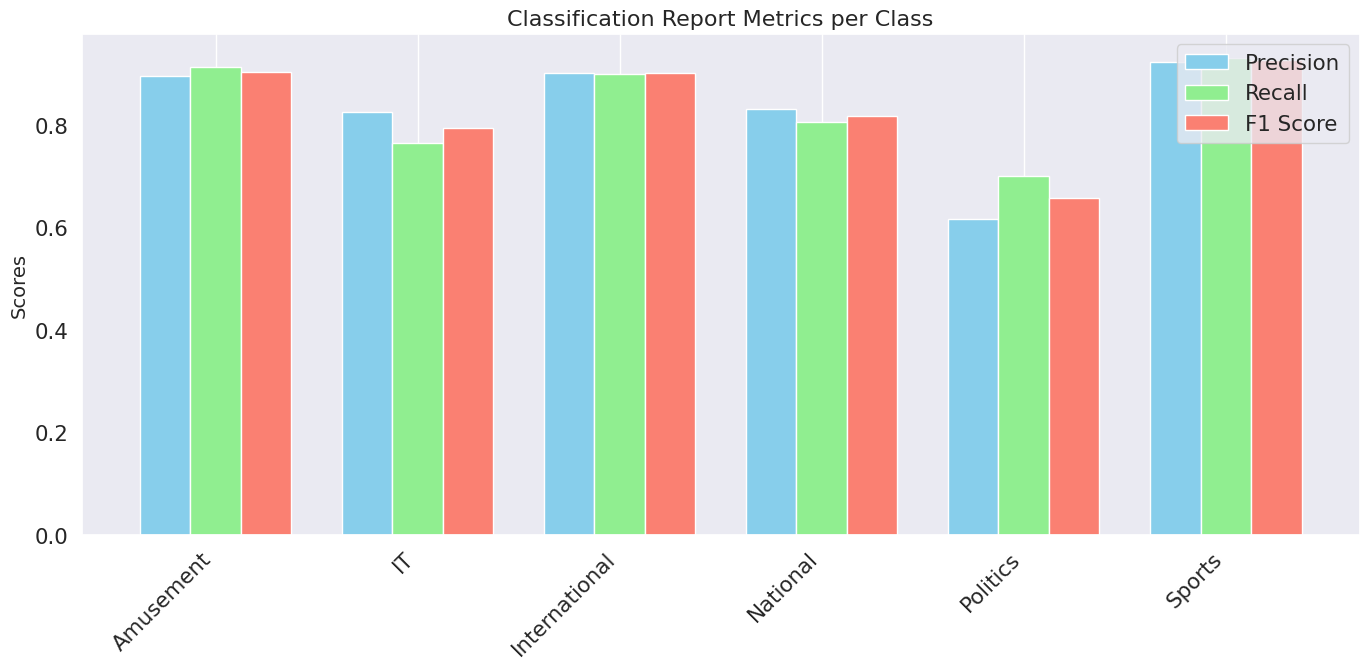

In [ ]:
# Classification Report as Bar Chart
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Get classification report as a dict
report_dict = classification_report(all_true, all_preds, target_names=le.classes_, output_dict=True)

# Extract Precision, Recall, F1-score
labels = list(le.classes_)
precision = [report_dict[label]['precision'] for label in labels]
recall = [report_dict[label]['recall'] for label in labels]
f1_score = [report_dict[label]['f1-score'] for label in labels]

x = np.arange(len(labels))  # Label locations
width = 0.25  # Width of bars

fig, ax = plt.subplots(figsize=(14, 7))

# Plot each metric
rects1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
rects2 = ax.bar(x, recall, width, label='Recall', color='lightgreen')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score', color='salmon')

# Labels and Title
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Classification Report Metrics per Class', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

# Grid and Layout
ax.grid(axis='y')
fig.tight_layout()

# Save the plot
plt.savefig('classification_report_bar_chart.png', dpi=300)  # High-quality PNG
plt.show()


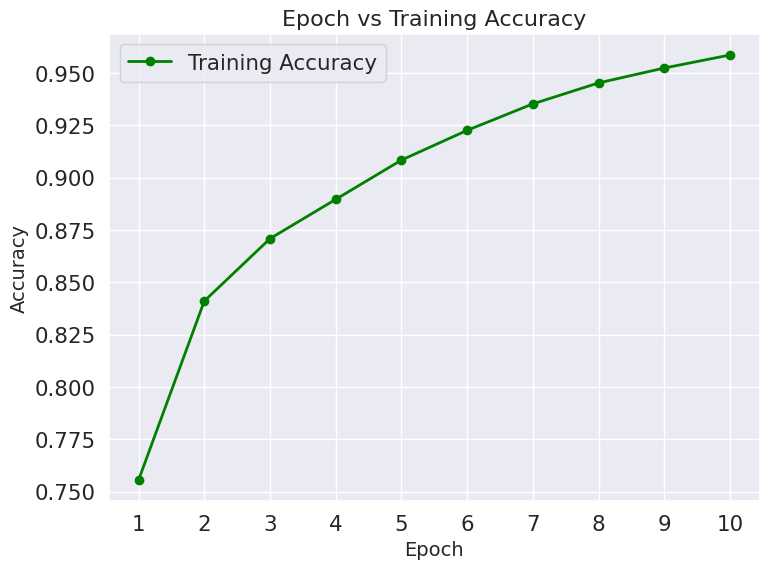

In [ ]:
# Epoch vs Accuracy Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
epochs_range = range(1, num_epochs + 1)

plt.plot(epochs_range, train_accuracies, color='green', marker='o', linestyle='-', linewidth=2, markersize=6, label='Training Accuracy')

plt.title('Epoch vs Training Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(epochs_range)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save high-res PNG
plt.savefig('epoch_vs_accuracy.png', dpi=300)
plt.show()


**END**

**XlmRoBERT**

In [ ]:
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Define models to evaluate
models = [
    "xlm-roberta-base"

]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

def load_custom_dataset():
    df = pd.read_excel('/content/drive/MyDrive/Bangla_News_Classification.xlsx', engine='openpyxl')
    df['headline'] = df['headline'].astype(str)

    # Convert 'category' column to numerical labels using LabelEncoder
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['category'])  # Encode labels numerically

    dataset = Dataset.from_pandas(df)
    return dataset.train_test_split(test_size=0.2)

dataset = load_custom_dataset()

# Run for each model
results = {}

# Define tokenize_function outside the loop with reduced sequence length
def tokenize_function(example, tokenizer):
    # Reduced sequence length further
    return tokenizer(example["headline"], padding="max_length", truncation=True, max_length=64)  # Reduced from 64 to 32

for model_name in models:
    print(f"Training {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)  # This loads the local cached version

    tokenized_datasets = dataset.map(lambda example: tokenize_function(example, tokenizer), batched=True)

    # Load model from the local cache
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(dataset["train"]["label"])))

    # Clear the GPU cache before training
    torch.cuda.empty_cache()

    # Define TrainingArguments inside the loop to access model_name
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=10,
        # Reduced batch size further
        per_device_train_batch_size=64,  # Reduced from 16 to 8
        per_device_eval_batch_size=32, # Reduced from 32 to 16
        weight_decay=0.03,
        logging_dir=f"./logs/{model_name}",
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        # Increased gradient accumulation steps
        gradient_accumulation_steps=4,  # Increased from 2 to 4
        # Enable mixed precision training (fp16)
        fp16=True,
        # Added gradient checkpointing
        gradient_checkpointing=True, # Saves memory by recomputing activations during backpropagation
    )

    # Instantiate Trainer outside the loop
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    metrics = trainer.evaluate()
    results[model_name] = metrics

# Print results
for model, metrics in results.items():
    print(f"{model} - Accuracy: {metrics['eval_accuracy']:.4f}, Precision: {metrics['eval_precision']:.4f}, Recall: {metrics['eval_recall']:.4f}, F1: {metrics['eval_f1']:.4f}")


Training xlm-roberta-base...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/57635 [00:00<?, ? examples/s]

Map:   0%|          | 0/14409 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-34507c115c9f>:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` paramete

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shakibabdullahmd3 (shakibabdullahmd3-rangamati-science-and-technology-unive) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.521800,0.488512,0.835936,0.835893,0.835936,0.835206
2,0.482000,0.417651,0.854327,0.853427,0.854327,0.853406
3,0.368200,0.426619,0.851621,0.862059,0.851621,0.852073
4,0.303300,0.404792,0.862100,0.869474,0.862100,0.863801
5,0.230200,0.415562,0.868207,0.871031,0.868207,0.869072
6,0.215800,0.435804,0.865987,0.871649,0.865987,0.866604
7,0.165800,0.460988,0.868485,0.873300,0.868485,0.869535


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.521800,0.488512,0.835936,0.835893,0.835936,0.835206
2,0.482000,0.417651,0.854327,0.853427,0.854327,0.853406
3,0.368200,0.426619,0.851621,0.862059,0.851621,0.852073
4,0.303300,0.404792,0.862100,0.869474,0.862100,0.863801
5,0.230200,0.415562,0.868207,0.871031,0.868207,0.869072
6,0.215800,0.435804,0.865987,0.871649,0.865987,0.866604
7,0.165800,0.460988,0.868485,0.873300,0.868485,0.869535
8,0.146800,0.463908,0.872788,0.872861,0.872788,0.872375
9,0.121100,0.493305,0.872094,0.874067,0.872094,0.872669


xlm-roberta-base - Accuracy: 0.8731, Precision: 0.8736, Recall: 0.8731, F1: 0.8731


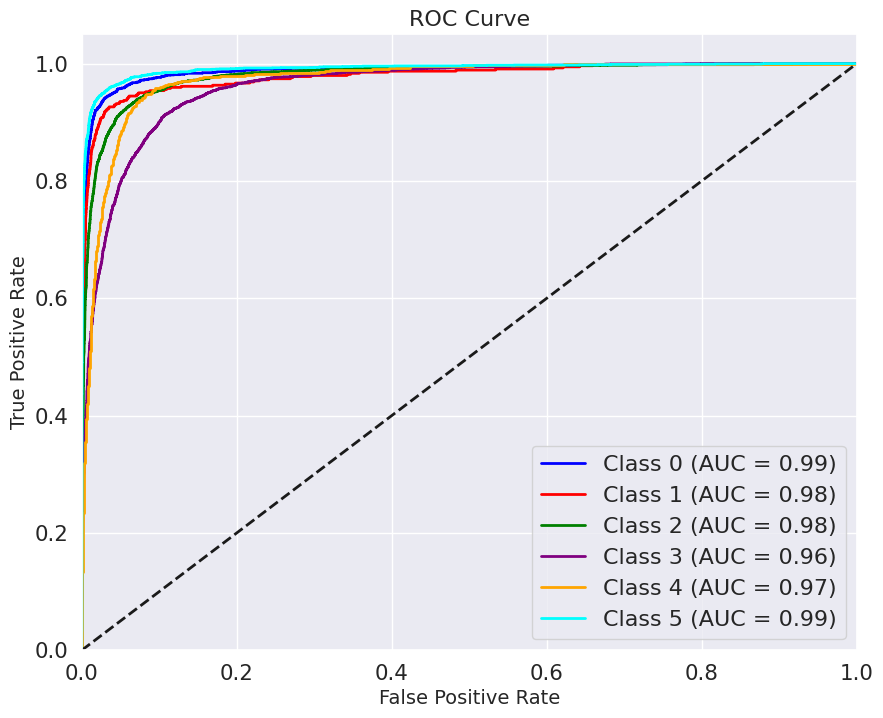

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

# Get predictions
predictions = trainer.predict(tokenized_datasets["test"])
logits = predictions.predictions
labels = predictions.label_ids

# Convert logits to probabilities
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

# Compute ROC curve and AUC for each class
n_classes = len(set(dataset["train"]["label"]))

# One-hot encode labels
from sklearn.preprocessing import label_binarize
labels_one_hot = label_binarize(labels, classes=list(range(n_classes)))

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(["blue", "red", "green", "purple", "orange", "cyan", "brown", "pink", "gray", "olive"])

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(labels_one_hot[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Plot diagonal line
plt.plot([0, 1], [0, 1], "k--", lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve", fontsize=16)
plt.legend(loc="lower right", fontsize=16)

# Save high-quality PNG
plt.savefig("roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()


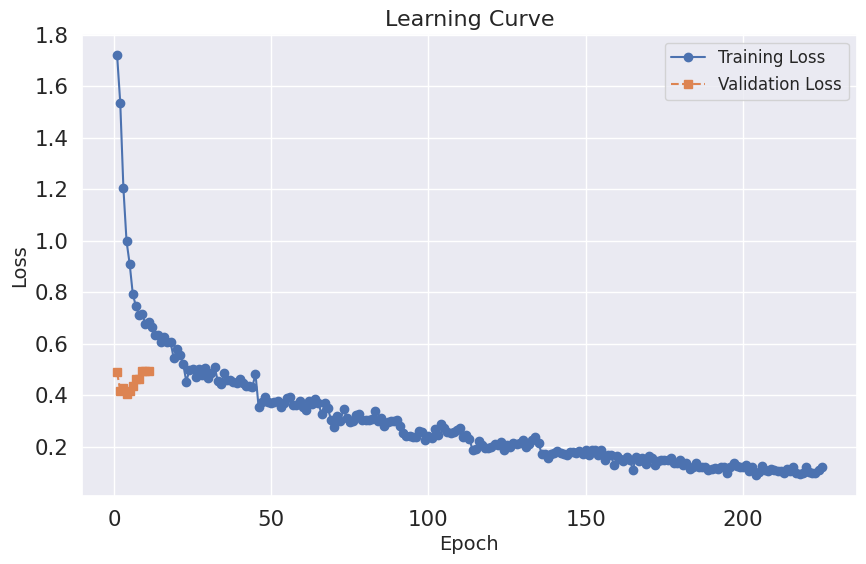

In [ ]:
import json
import matplotlib.pyplot as plt

# Load training logs
log_history = trainer.state.log_history

# Extract loss values
train_losses = [entry["loss"] for entry in log_history if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
epochs = list(range(1, len(train_losses) + 1))

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker='o', linestyle='-')
plt.plot(epochs[:len(eval_losses)], eval_losses, label="Validation Loss", marker='s', linestyle='--')

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Learning Curve", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Save high-quality PNG
plt.savefig("learning_curve.png", dpi=300, bbox_inches="tight")
plt.show()


**Train vs test learning curve**

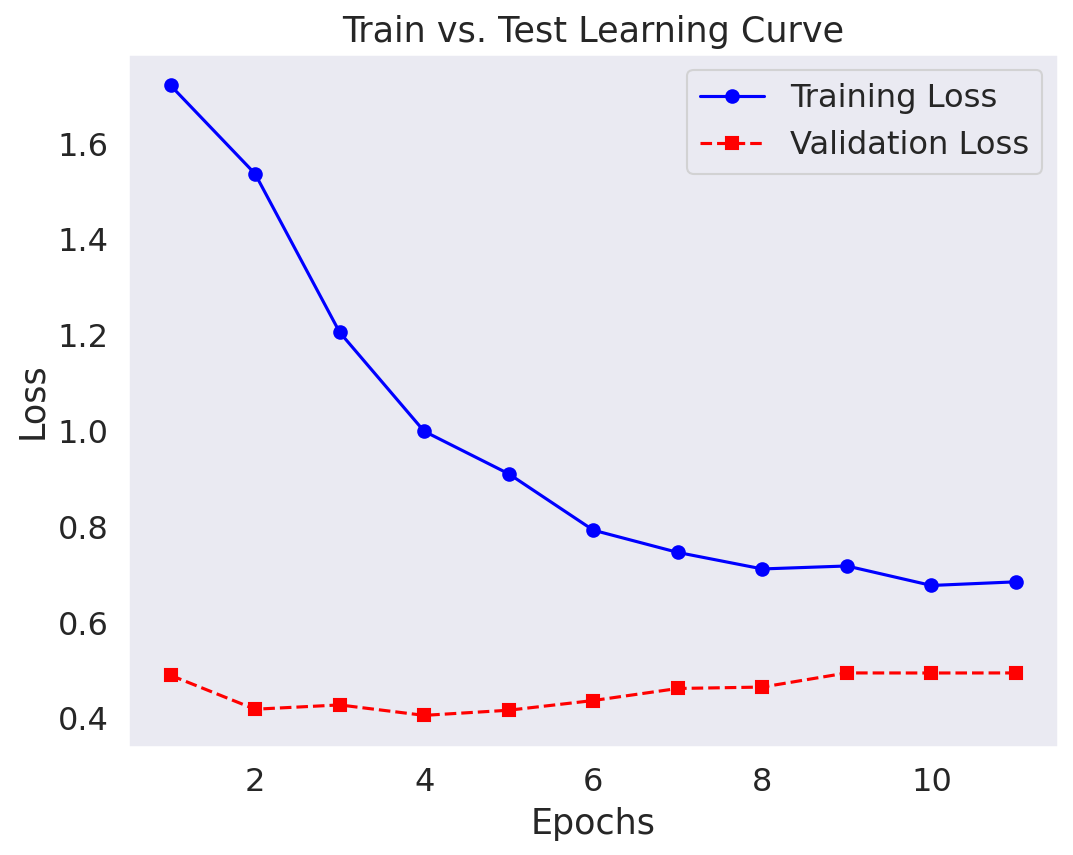

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation losses from Trainer's log history
history = trainer.state.log_history

# Separate train loss and eval loss
train_loss = [entry["loss"] for entry in history if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in history if "eval_loss" in entry]

# Ensure both lists are the same length (in case of early stopping)
min_length = min(len(train_loss), len(eval_loss))
train_loss = train_loss[:min_length]
eval_loss = eval_loss[:min_length]

# Create an epoch range for plotting
epochs = range(1, min_length + 1)

# Plot Train vs. Test Learning Curve
plt.figure(figsize=(8, 6), dpi=150)  # High resolution
plt.plot(epochs, train_loss, label="Training Loss", marker="o", linestyle="-", color="blue")
plt.plot(epochs, eval_loss, label="Validation Loss", marker="s", linestyle="--", color="red")

# Labels and Title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs. Test Learning Curve")
plt.legend()
plt.grid()

# Save as high-quality PNG
plt.savefig("train_vs_test_learning_curve.png", dpi=150, bbox_inches="tight")
plt.show()


**Epoch vs Accuracy curve**

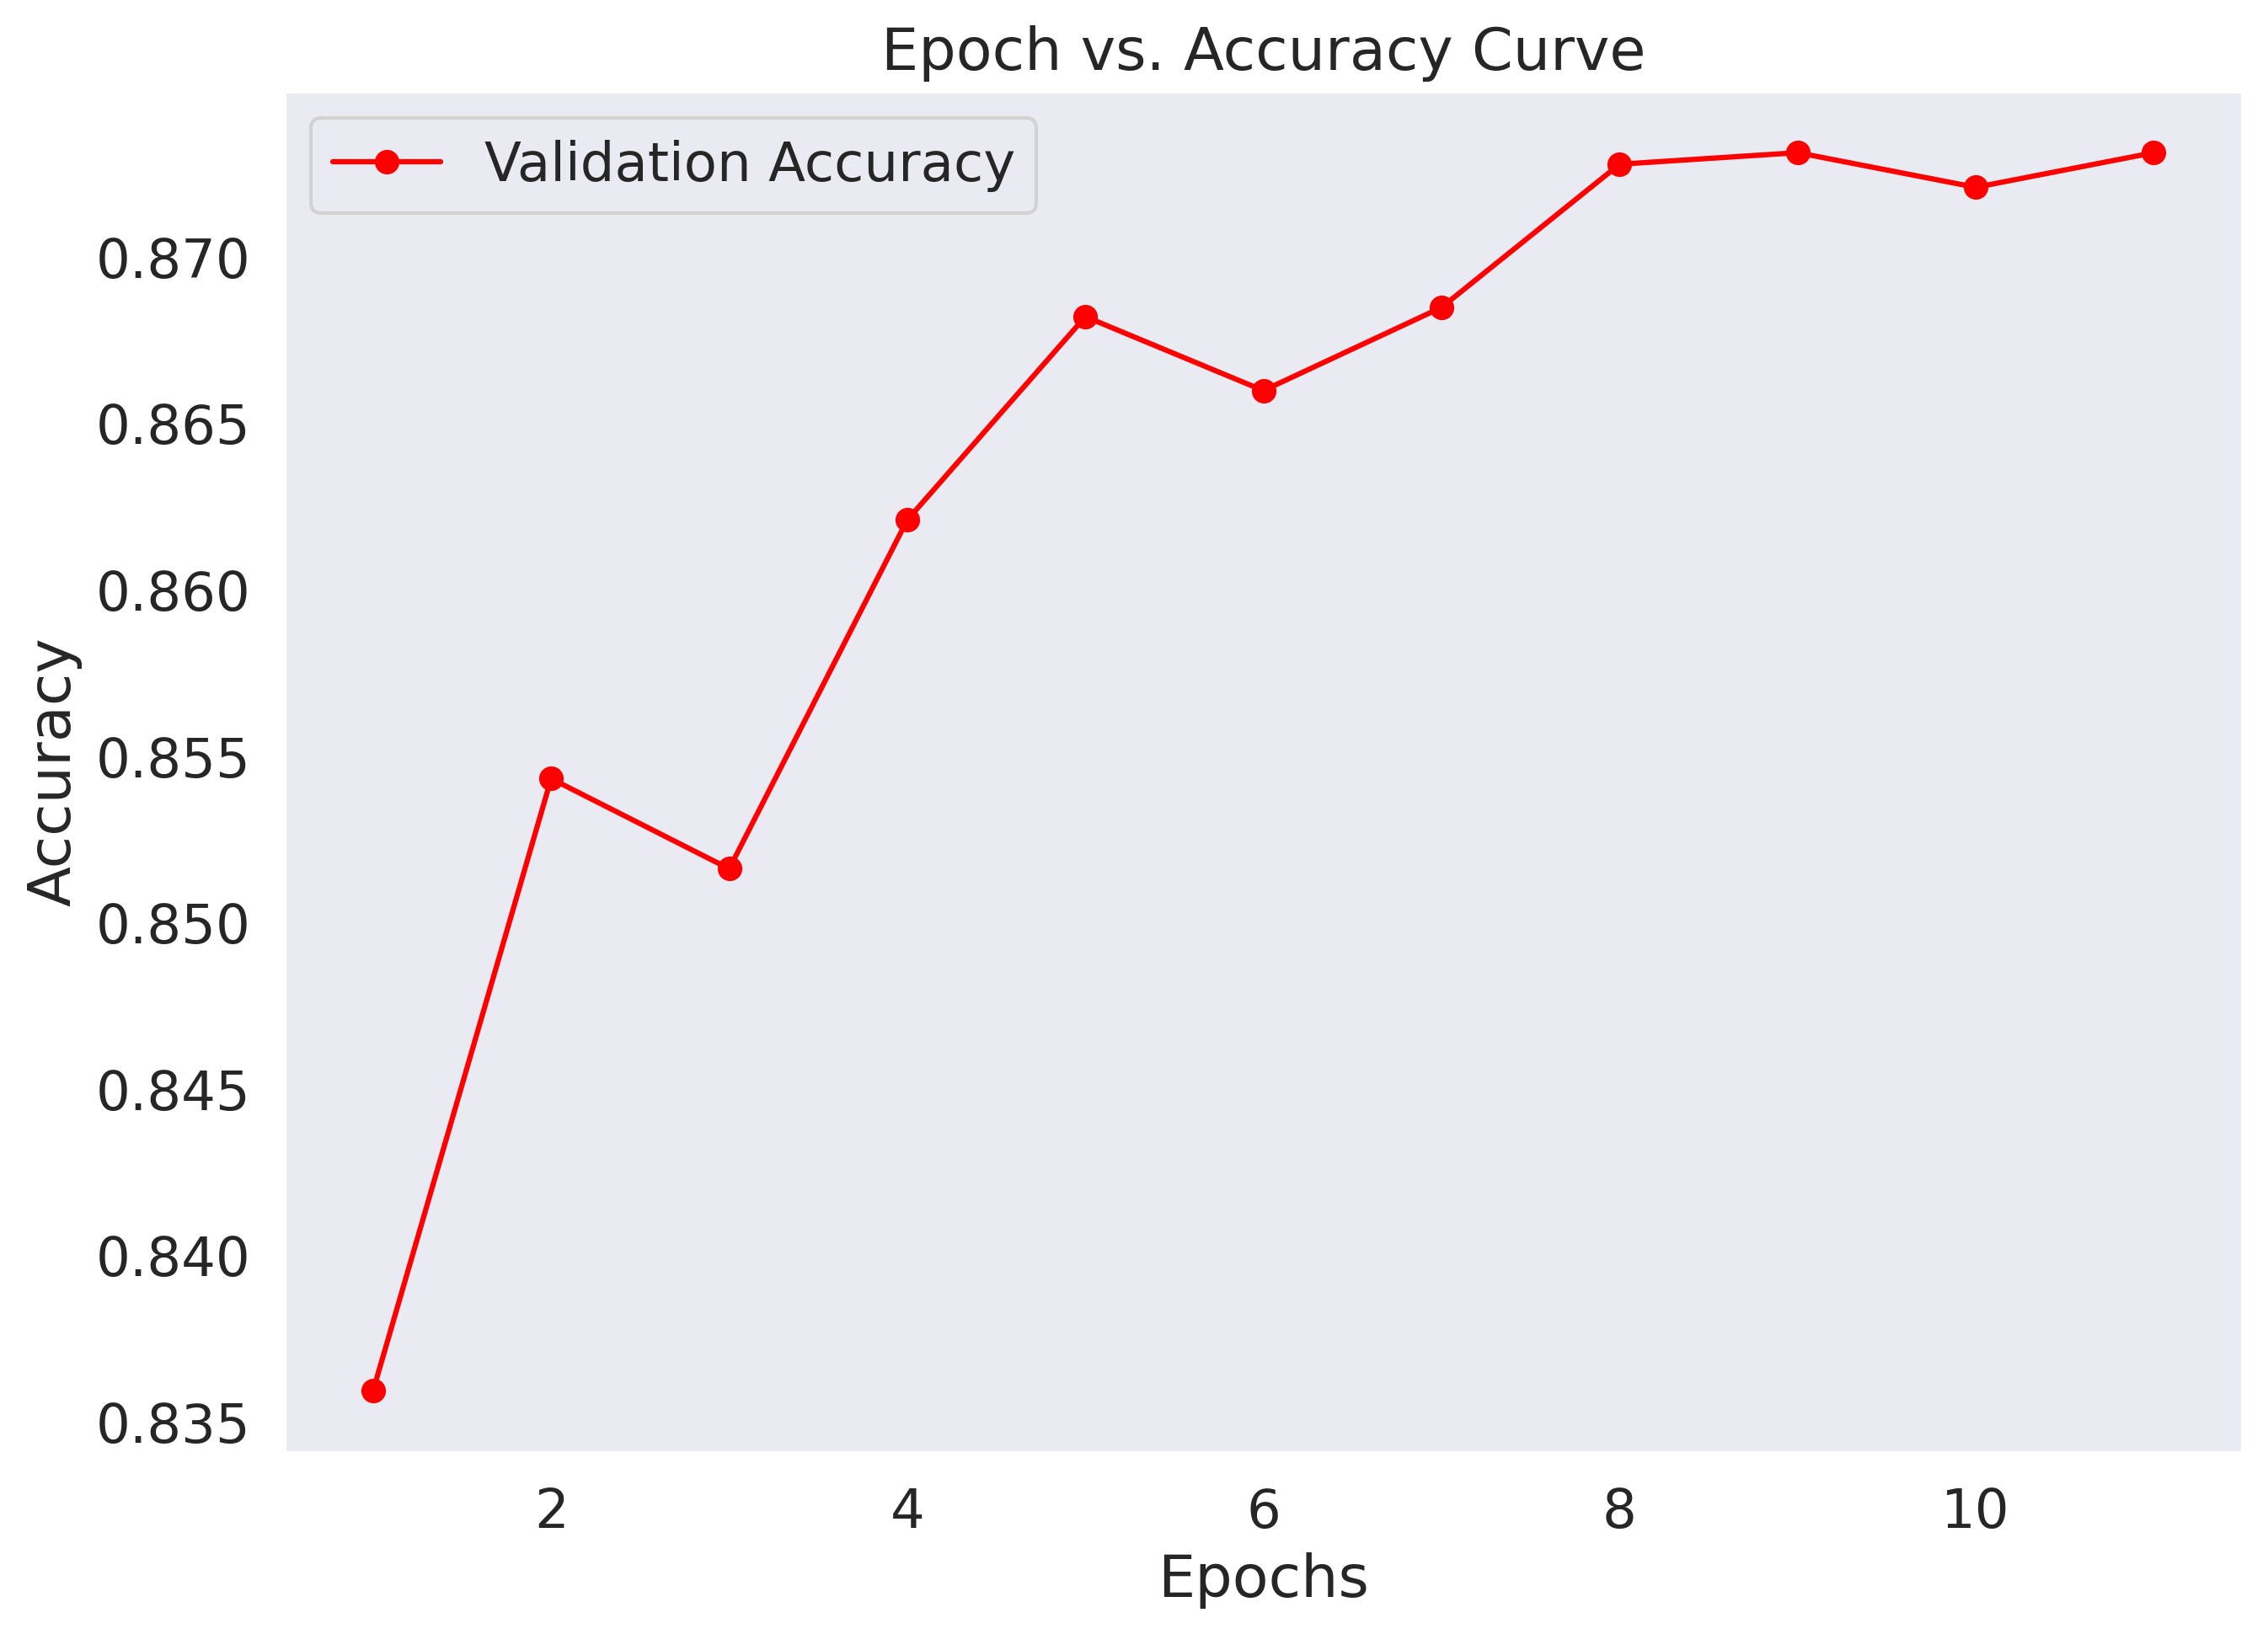

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracies from Trainer's log history
history = trainer.state.log_history

# Extract evaluation accuracy from log history
eval_accuracy = [entry["eval_accuracy"] for entry in history if "eval_accuracy" in entry]

# Generate epochs based on available accuracy logs
epochs = range(1, len(eval_accuracy) + 1)

# Plot Epoch vs. Accuracy Curve
plt.figure(figsize=(10, 7), dpi=300)  # High resolution
plt.plot(epochs, eval_accuracy, label="Validation Accuracy", marker="o", linestyle="-", color="red")

# Labels and Title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epoch vs. Accuracy Curve")
plt.legend()
plt.grid()

# Save as high-quality PNG
plt.savefig("epoch_vs_accuracy_curve.png", dpi=300, bbox_inches="tight")
plt.show()


**Epoch vs Test accuracy**

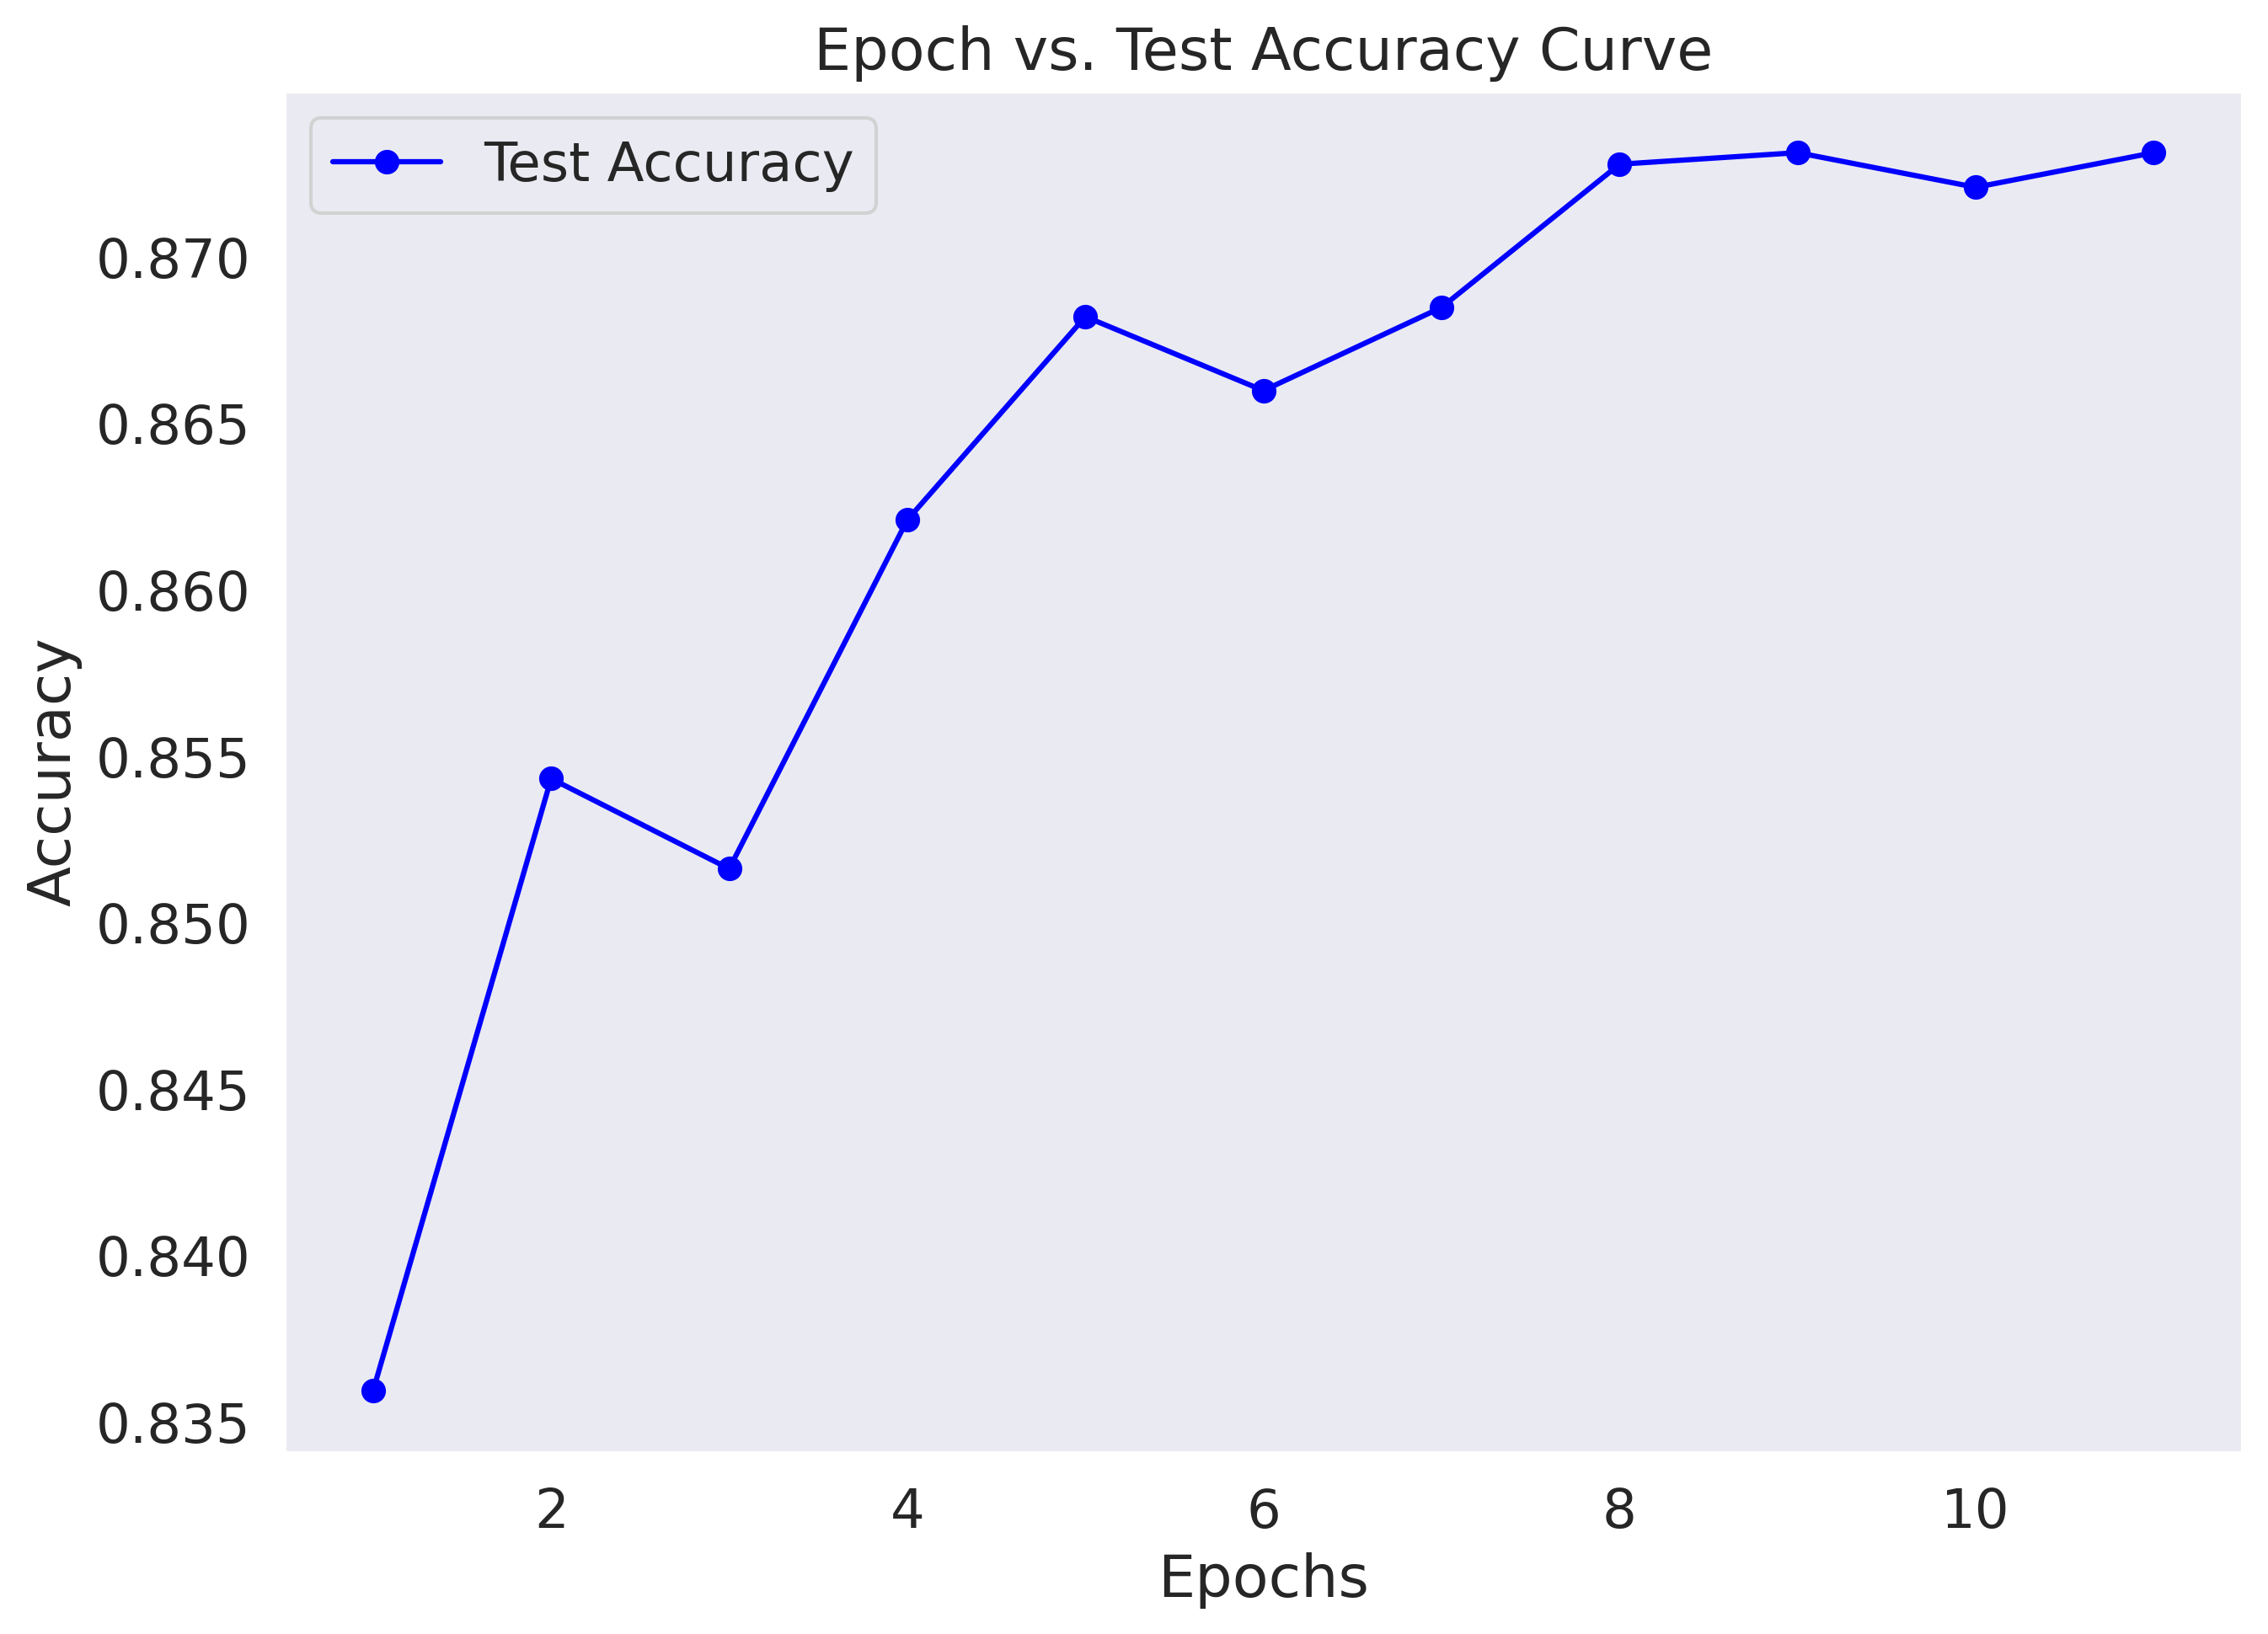

In [ ]:
import matplotlib.pyplot as plt

# Extract test accuracy from Trainer's log history
history = trainer.state.log_history

# Extract test accuracy (evaluation accuracy)
test_accuracy = [entry["eval_accuracy"] for entry in history if "eval_accuracy" in entry]

# Generate epoch numbers
epochs = range(1, len(test_accuracy) + 1)

# Plot Epoch vs. Test Accuracy Curve
plt.figure(figsize=(10, 7), dpi=300)  # High resolution
plt.plot(epochs, test_accuracy, label="Test Accuracy", marker="o", linestyle="-", color="blue")

# Labels and Title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epoch vs. Test Accuracy Curve")
plt.legend()
plt.grid()

# Save as high-quality PNG
plt.savefig("epoch_vs_test_accuracy_curve.png", dpi=300, bbox_inches="tight")
plt.show()


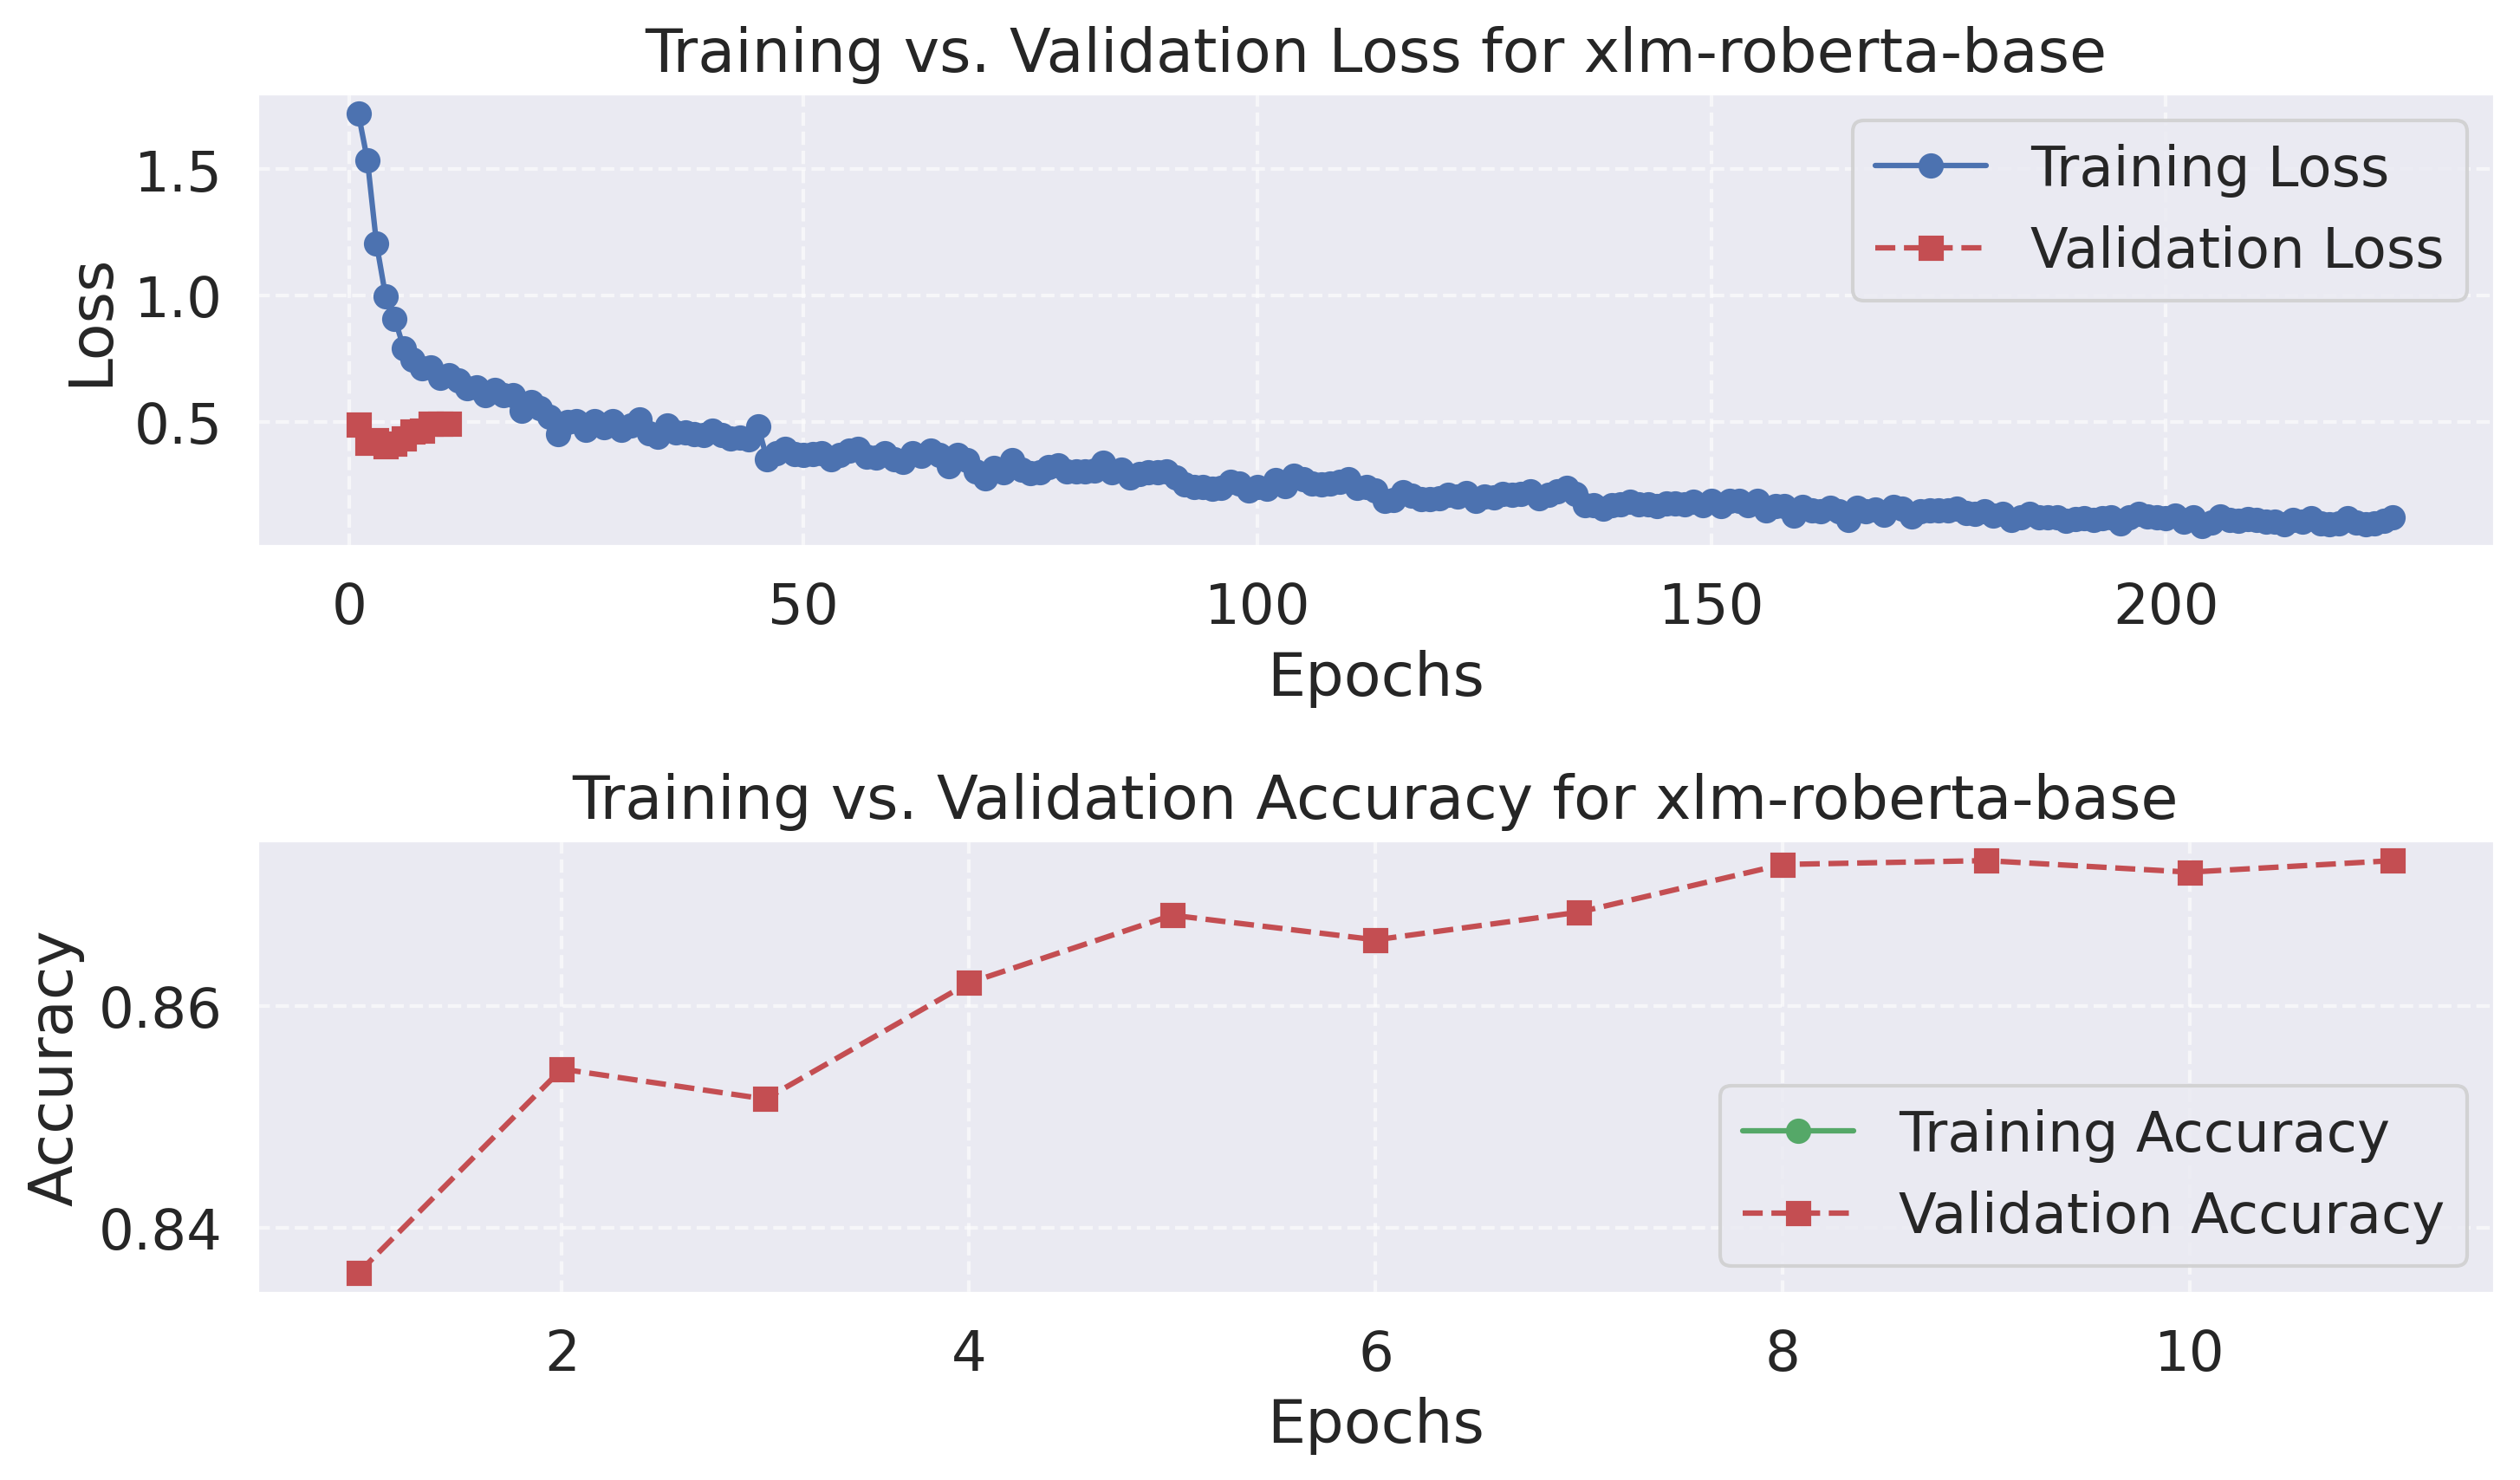

In [ ]:
import matplotlib.pyplot as plt

def plot_train_test_curve(trainer, model_name):
    logs = trainer.state.log_history
    train_losses = [entry['loss'] for entry in logs if 'loss' in entry]
    eval_losses = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]
    train_accuracies = [entry['accuracy'] for entry in logs if 'accuracy' in entry]
    eval_accuracies = [entry['eval_accuracy'] for entry in logs if 'eval_accuracy' in entry]

    # Create separate epoch ranges for training and evaluation data
    epochs_train = list(range(1, len(train_losses) + 1))
    epochs_eval = list(range(1, len(eval_losses) + 1))

    plt.figure(figsize=(10, 6), dpi=300)  # High-resolution PNG

    # Plot loss curves
    plt.subplot(2, 1, 1)
    plt.plot(epochs_train, train_losses, label='Training Loss', marker='o', linestyle='-', color='b')
    plt.plot(epochs_eval, eval_losses, label='Validation Loss', marker='s', linestyle='--', color='r') # Use epochs_eval here
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training vs. Validation Loss for {model_name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot accuracy curves
    plt.subplot(2, 1, 2)

    # Create separate epoch ranges for training and evaluation accuracy
    epochs_train_acc = list(range(1, len(train_accuracies) + 1))
    epochs_eval_acc = list(range(1, len(eval_accuracies) + 1))

    plt.plot(epochs_train_acc, train_accuracies, label='Training Accuracy', marker='o', linestyle='-', color='g') # Use epochs_train_acc
    plt.plot(epochs_eval_acc, eval_accuracies, label='Validation Accuracy', marker='s', linestyle='--', color='r') # Use epochs_eval_acc
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training vs. Validation Accuracy for {model_name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    # Save the plot as high-quality PNG
    plt.savefig(f'{model_name}_train_vs_test_curve.png', format='png', dpi=300)
    plt.show()

# Call the function for the trained model
for model_name in models:
    plot_train_test_curve(trainer, model_name)